# Non deep learning models

### Todo


Tune our complex models

Try PCA/Auto encoder approaches

add n_jobs so that it can be run on hot cpus as well

Perhaps eliminate Random Forest as is it boosted trees run with a specific parameter set
Seems to always give worse results than boosted and might therefore be redundant

add safety for overwriting

add show p values for logistic regression

add decision tree

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [131]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics as met
from scipy import stats
import json

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

#Here we set a seed so that our random search produce the same result 
np.random.seed(31415)

# Here we create a scoring dictionary which defines the metrics we report on in cross validation
scoring = {
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score),
    "MCC" : met.make_scorer(met.matthews_corrcoef)
}

# This is the metric we seek to optimise through tuning
refit = "MCC"

# Which folder of preprocessed data we want to use
FOLDER_NAME = "example"

#Whether to print information about the percentage of positive cases in our train and test sets
POSITIVE_CASES_PRINT = 0

#### In this cell we import our training data and drop PATNO and SMOTE helper colums

In [132]:
train = pd.read_csv(FOLDER_NAME + '/train.csv')

#We read our SMOTE helper column into a variable and then drop it
SAMPLING = train.SAMPLING.values[0]
train.drop(["SAMPLING"], axis = 1, inplace = True)


# We drop PATNO
train.drop(["PATNO"], axis = 1, inplace = True)


# We form Y
train_Y = train.pop("HALL")



if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in training set", train.shape)
    print("Number of patients which hallucinates eventually in training set is ",  sum(train_Y), " which is ", sum(train_Y)/ (train_Y.size), " percent of patients")

#Important for xgboost class weight balancing
num_pos_samples = sum(train_Y)
num_neg_samples = train_Y.size - num_pos_samples
pos_weights_scale = num_neg_samples / num_pos_samples

#### In this cell we import our test data (if flag is set) and drop PATNO and SMOTE helper columns

In [133]:
test = pd.read_csv(FOLDER_NAME + '/test.csv')

# We form Y
test_Y = test.pop("HALL")

if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in test set", test.shape)
    print("Number of patients which hallucinates eventually in test set is ",  sum(test_Y), " which is ", sum(test_Y)/ (test_Y.size), " percent of patients")


#### In this cell we define our sampling (SMOTE currently) functions

In [134]:
import imblearn as imbl

def over_sampling(model, X):
    
    categorical_columns = []
    
    for c in X.columns:
        if "C_" in c:
            categorical_columns.append(c)
            
    categorical_columns = [X.columns.get_loc(c) for c in categorical_columns]

    pipeline = imbl.pipeline.make_pipeline(imbl.over_sampling.SMOTENC(categorical_columns, sampling_strategy = 1),
                                          model)
    
    return pipeline

#### In this cell we define general functions for hyperparameter tuning and cross validation using sklearn functions

In [135]:
import copy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

'''
metrics from sklearn that we can put into scoring variable:
‘accuracy’
‘balanced_accuracy’
‘average_precision’
‘neg_brier_score’
‘f1’
‘neg_log_loss’
‘precision’ etc.
‘recall’ etc.
‘jaccard’ etc.
‘roc_auc’
'''
def randomized_tuning (X,Y, model, param_dist, k_folds, n_iter, scoring_metrics, scoring_refit, sampling):
    '''
    model should be a XGBClassifier or sklearn classifier 
    param_dist can look like this, remember that it a randomized search through distributions, not a grid search:
    param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
    k_folds = number of folds in CV
    n_iter = number of different random combination of parameters tried. More iterations gives a higher chance of finding the best parameters
    scoring metrics = the metrics the search wil report on a the end, example: ['roc_auc', 'f1']
    scoring_refit = The single metric that will be used to find a "best estimator" at the end,  pick one metric from your scoring metrics list. e.g "f1" or 
    set to False if manually finding best estimator
    '''
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_dist = copy.deepcopy(param_dist)
            param_dist = {model_string + "__" + key: param_dist[key] for key in param_dist}
                
    clf = RandomizedSearchCV(model, param_distributions = param_dist, cv = k_folds, n_iter = n_iter, scoring = scoring_metrics, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = 4, return_train_score = True)
    '''
    If scoring_refit is set you can get the best params on that metric by return.best_params_
    Manual inspection can be done by pd.DataFrame(return.cv_results_)
    '''
    params = clf.fit(X,Y).best_params_
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_dist = temp_param_dist
    
    for k, v in param_dist.items():
        if not isinstance(v, list):
            print("\nFor hyperparameter", k, " possible interval was : [" , v.interval(1)[0], ",", v.interval(1)[1], "]. The value chosen by RandomSearch is: ", params[k])
        else:
            values_string = "["
            for i in v:
                values_string += str(i) + ","
            values_string += "]"
            print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)    
    
    return params


def grid_tuning(X,Y, model, param_grid, k_folds, scoring_metrics, scoring_refit, sampling):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_grid = copy.deepcopy(param_grid)
            param_grid = {model_string + "__" + key: param_grid[key] for key in param_grid}
            
    clf = GridSearchCV(model, param_grid = param_grid, cv = k_folds, scoring = scoring_metrics, refit = scoring_refit, \
                         error_score = 0, verbose = 1, n_jobs = 4, return_train_score = True)
    
    params = clf.fit(X,Y).best_params_
    
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_grid = temp_param_grid
        
    for k, v in param_grid.items():
        values_string = "["
        for i in v:
            values_string += str(i) + ","
        values_string += "]"
        print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)
    return params


def CV_report (model, X, Y, k_folds, scoring, sampling):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
        
    cv_results = cross_validate(model, X, Y, cv= k_folds, scoring= scoring, n_jobs = 4,  verbose = 1, return_train_score = True)
    
    df = pd.DataFrame(columns = ["Metric", "Train mean", "Train SD", "Test mean", "Test SD"])
    rows_list = []
    for x in scoring:
        score_dict = {}
        score_dict["Metric"] = x
        score_dict["Train mean"] = np.mean(cv_results["train_" + x])
        score_dict["Train SD"] = np.std(cv_results["train_" + x])
        score_dict["Test mean"] = np.mean(cv_results["test_" + x])
        score_dict["Test SD"] = np.std(cv_results["test_" + x])  
        rows_list.append(score_dict)
    print("\nCV Report:")  
    print("\n", df.append(pd.DataFrame(rows_list), sort = False))

#### In this cell we set all flags and parameters for Logistic Regression

In [136]:
'''
    Flags and Parameters for Logistic Regression
'''
# 0 = No, 1 = Yes
ENABLE_LOGISTIC_REGRESSION = 0

#Number of folds to use in CV
LOGISTIC_REGRESSION_K_FOLD = 10

if ENABLE_LOGISTIC_REGRESSION:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK = 1

    if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #LOGISTIC_REGRESSION_[FILE_NAME].txt
        LOGISTIC_REGRESSION_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    LOGISTIC_REGRESSION_TUNING_METHOD = 1
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "lbfgs",
            "class_weight": "balanced",
            "n_jobs": 4,
            "C" : 5
        }
    
    
    elif LOGISTIC_REGRESSION_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "lbfgs",
            "class_weight": "balanced",
            "n_jobs": 4
        }
        
        if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH = { 'C' : stats.uniform(0.0, 10)
                         }
            
            
        elif LOGISTIC_REGRESSION_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH = { 'C' : [0,0.05,0.1]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do our logistic regression

In [137]:
from sklearn.linear_model import LogisticRegression

if ENABLE_LOGISTIC_REGRESSION:
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        params = randomized_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH, LOGISTIC_REGRESSION_K_FOLD, \
                                   LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 2:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        params = grid_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH, LOGISTIC_REGRESSION_K_FOLD, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)

if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
    print("\nSaving hyperparameters to disk")
    params = clf_log.get_params()
    with open(output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_FILE_NAME + '.txt', 'w') as f:
        json.dump(params, f)


Saving hyperparameters to disk


#### In this cell we set all flags and parameters for Random Forest

In [138]:
'''
    Flags and Parameters for Random Forest
'''
# 0 = No, 1 = Yes
ENABLE_RANDOM_FOREST = 0

#Number of folds to use in CV
RANDOM_FOREST_K_FOLD = 10

if ENABLE_RANDOM_FOREST:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SAVE_PARAMS_TO_DISK = 1

    if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #RANDOM_FOREST_[FILE_NAME].txt
        RANDOM_FOREST_FILE_NAME = "bestparams"
    
    #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE = 1
    if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW = 15
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    RANDOM_FOREST_TUNING_METHOD = 1
    
    if RANDOM_FOREST_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        RANDOM_FOREST_PARAMS = {
          'colsample_bynode': 0.8,
            'n_estimators' : 1,
          'learning_rate': 1,
          'max_depth': 5,
          'num_parallel_tree': 100,
          'objective': 'binary:logistic',
          'subsample': 0.8,
          'scale_pos_weight' : pos_weights_scale
        }
    
    
    elif RANDOM_FOREST_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        RANDOM_FOREST_PARAMS = {
            'n_estimators' : 1,
            'learning_rate': 1,
            'objective': 'binary:logistic',
            'scale_pos_weight' : pos_weights_scale
        }
        
        if RANDOM_FOREST_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            RANDOM_FOREST_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            RANDOM_FOREST_PARAMS_RANDOM_SEARCH = { 'colsample_bynode': stats.uniform(0.5, 0.45),
              'max_depth': stats.randint(3,9),
              'subsample': stats.uniform(0.3, 0.6),
              'num_parallel_tree': stats.randint(50,200), 
              'max_delta_step' : stats.uniform(0,15)
             }
            
            
        elif RANDOM_FOREST_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            RANDOM_FOREST_PARAMS_GRID_SEARCH = { 'colsample_bynode': [0.5,0.75],
              'max_depth': [3, 7],             
              'subsample': [0.5,0.75],
              'num_parallel_tree': [2,5],
              'max_delta_step' : [0,5]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do random forest from XGBOOST


Saving hyperparameters to disk
Plot of feature importance:


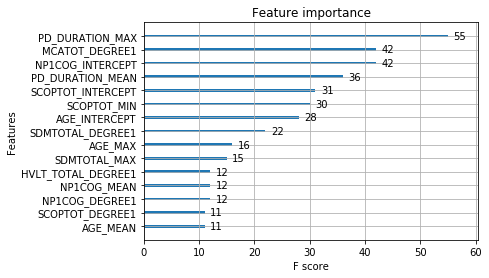

In [139]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

if ENABLE_RANDOM_FOREST:
    
    if RANDOM_FOREST_TUNING_METHOD == 0:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
    if RANDOM_FOREST_TUNING_METHOD == 1:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        params = randomized_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_RANDOM_SEARCH, RANDOM_FOREST_K_FOLD, \
                                   RANDOM_FOREST_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
        
    if RANDOM_FOREST_TUNING_METHOD == 2:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        params = grid_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_GRID_SEARCH, RANDOM_FOREST_K_FOLD, scoring, refit, SAMPLING)
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)

if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
    print("\nSaving hyperparameters to disk")
    params = clf_RF.get_params()
    with open(output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + RANDOM_FOREST_FILE_NAME + '.txt', 'w') as f:
        json.dump(params, f)
        
if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
    print("Plot of feature importance:")
    xgb.plot_importance(clf_RF.fit(train,train_Y), max_num_features = RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW)
    pyplot.show()  

#### In this cell we set all flags and parameters for boosted trees

In [146]:
'''
    Flags and Parameters for boosted trees
'''
# 0 = No, 1 = Yes
ENABLE_BOOSTED_TREES = 1

#Number of folds to use in CV
BOOSTED_TREES_K_FOLD = 10

if ENABLE_BOOSTED_TREES:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SAVE_PARAMS_TO_DISK = 1

    if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #BOOSTED_TREES_[FILE_NAME].txt
        BOOSTED_TREES_FILE_NAME = "bestparams"
    
     #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE = 1
    if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW = 15
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    BOOSTED_TREES_TUNING_METHOD = 1
    
    if BOOSTED_TREES_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        BOOSTED_TREES_PARAMS = {
            'n_estimators' : 2,
            'learning_rate': 1,
            'max_depth': 2,
            'objective': 'binary:logistic',
            'scale_pos_weight':  pos_weights_scale
        }
    
    
    elif BOOSTED_TREES_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        BOOSTED_TREES_PARAMS = {
            'objective': 'binary:logistic',
            'scale_pos_weight' : pos_weights_scale
        }
        
        if BOOSTED_TREES_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            BOOSTED_TREES_RANDOMSEARCH_N_ITER = 20
            
            #Use this to define the distributions to search through in randomsearch
            BOOSTED_TREES_PARAMS_RANDOM_SEARCH = {'n_estimators': stats.randint(1, 100),
              'learning_rate': stats.uniform(0.01, 0.99),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': stats.randint(3,9),
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': stats.randint(1,3),
              'max_delta_step' : stats.uniform(0,15),
             }
            
            
        elif BOOSTED_TREES_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            BOOSTED_TREES_PARAMS_GRID_SEARCH = {'n_estimators': [1,50],
              'learning_rate': [0.1,0.2],
              'subsample': [0.3,0.5],
              'max_depth': [3,5],
              'colsample_bytree': [0.5,0,7],
              'min_child_weight': [1,3],
              'max_delta_step' : [5,10],
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do boosted trees from XGBOOST

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished



For hyperparameter n_estimators  possible interval was : [ 0.0 , 99.0 ]. The value chosen by RandomSearch is:  22

For hyperparameter learning_rate  possible interval was : [ 0.01 , 1.0 ]. The value chosen by RandomSearch is:  0.4122651810060856

For hyperparameter subsample  possible interval was : [ 0.3 , 1.0 ]. The value chosen by RandomSearch is:  0.7767598658908296

For hyperparameter max_depth  possible interval was : [ 2.0 , 8.0 ]. The value chosen by RandomSearch is:  4

For hyperparameter colsample_bytree  possible interval was : [ 0.5 , 0.95 ]. The value chosen by RandomSearch is:  0.5608767751589773

For hyperparameter min_child_weight  possible interval was : [ 0.0 , 2.0 ]. The value chosen by RandomSearch is:  1

For hyperparameter max_delta_step  possible interval was : [ 0.0 , 15.0 ]. The value chosen by RandomSearch is:  7.912386356188415
Optimized for  MCC

CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy         1.0       0.0   0.

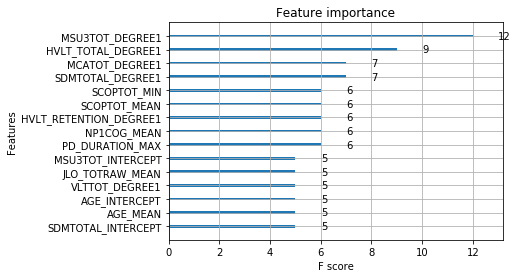

In [147]:
from xgboost.sklearn import XGBClassifier

if ENABLE_BOOSTED_TREES:
    
    if BOOSTED_TREES_TUNING_METHOD == 0:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
    if BOOSTED_TREES_TUNING_METHOD == 1:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        params = randomized_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_RANDOM_SEARCH, BOOSTED_TREES_K_FOLD, \
                                   BOOSTED_TREES_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
        
    if BOOSTED_TREES_TUNING_METHOD == 2:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        params = grid_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_GRID_SEARCH, BOOSTED_TREES_K_FOLD, scoring, refit, SAMPLING)
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)

if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
    print("\nSaving hyperparameters to disk")
    params = clf_BT.get_params()
    with open(output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + BOOSTED_TREES_FILE_NAME + '.txt', 'w') as f:
        json.dump(params, f)
        
if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
    print("Plot of feature importance:")
    xgb.plot_importance(clf_BT.fit(train,train_Y), max_num_features = BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW)
    pyplot.show()  

#### In this cell we set all flags and parameters for Support Vector Machines

In [ ]:
'''
    Flags and Parameters for Support Vector Machines
'''
# 0 = No, 1 = Yes
ENABLE_SVM = 0

#Number of folds to use in CV
SVM_K_FOLD = 10

if ENABLE_SVM:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    SVM_SAVE_PARAMS_TO_DISK = 1

    if SVM_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #SVM_[FILE_NAME].txt
        SVM_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    SVM_TUNING_METHOD = 2
    
    if SVM_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        SVM_PARAMS = {
            "kernel" : "linear",
            "class_weight": "balanced",
            "C" : 5
        }
    
    
    elif SVM_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        SVM_PARAMS = {
            "class_weight": "balanced",
        }
        
        if SVM_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            SVM_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            SVM_PARAMS_RANDOM_SEARCH = { 
                'kernel' : ["linear", "poly", "rbf", "sigmoid", "precomputed"],
                'C' : stats.uniform(0.0, 10)
                         }
            
            
        elif SVM_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            SVM_PARAMS_GRID_SEARCH = { 
                'kernel' : ["linear", "poly", "rbf", "sigmoid", "precomputed"],
                'C' : [0,0.05,0.1]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we apply SVM from scikit-learn

In [ ]:
from sklearn import svm

if ENABLE_SVM:
    
    if SVM_TUNING_METHOD == 0:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
    if SVM_TUNING_METHOD == 1:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        params = randomized_tuning(train,train_Y,clf_svm, SVM_PARAMS_RANDOM_SEARCH, SVM_K_FOLD, \
                                   SVM_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
        
    if SVM_TUNING_METHOD == 2:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        params = grid_tuning(train,train_Y,clf_svm, SVM_PARAMS_GRID_SEARCH, SVM_K_FOLD, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)

if SVM_SAVE_PARAMS_TO_DISK:
    print("\nSaving hyperparameters to disk")
    params = clf_svm.get_params()
    with open(output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_FILE_NAME + '.txt', 'w') as f:
        json.dump(params, f)
